In [1]:
from point2vec.models import PointMAE
from glob import glob
import os

def get_newest_ckpt(ckpt_path):
    ckpt_path = glob(f'{ckpt_path}/**/*.ckpt')
    newest_ckpt = max(ckpt_path, key=os.path.getctime)
    return newest_ckpt

wandb_run_id = 'fjnp0snd'
ckpt_path = f'/sdf/home/y/youngsam/sw/dune/representations/point2vec/PointMAE-Pretraining-LArNet-5voxel/{wandb_run_id}'

model = PointMAE.load_from_checkpoint(
    get_newest_ckpt(ckpt_path)
).cuda()
model.eval();

/sdf/home/y/youngsam/sw/dune/.conda/envs/py310/lib/python3.10/site-packages/lightning_fabric/utilities/cloud_io.py:48: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  return t

I assume you have already run `00_dataset.ipynb` and have the dataset format understood.

# Dataset Initialization

In [2]:
from point2vec.datasets import LArNetDataModule
import matplotlib.pyplot as plt
import torch
import numpy as np
torch.set_grad_enabled(False)

dataset = LArNetDataModule(
    data_path=f'/sdf/home/y/youngsam/data/dune/larnet/h5/DataAccessExamples/train/generic_v2*.h5',
    batch_size=24,
    num_workers=0,
    dataset_kwargs={
        'emin': 1.0e-6,                      # min energy for log transform
        'emax': 20.0,                        # max energy for log transform
        'energy_threshold': 0.13,            # remove points with energy < 0.13
        'remove_low_energy_scatters': True,  # remove low energy scatters (PID=4)
        'maxlen': -1,                        # max number of events to load
        'normalize': True,                   # normalize point cloud to unit sphere
    }
)
dataset.setup()

# DataLoader
train_loader = dataset.train_dataloader()

# Inference
for batch in train_loader:
    points, lengths, semantic_id, endpoints = batch
    points = points.cuda()
    lengths = lengths.cuda()
    break

[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 864064 point clouds were loaded
[DATASET] 10 files were loaded
[DATASET] self.emin=1e-06, self.emax=20.0, self.energy_threshold=0.13, self.normalize=True, self.remove_low_energy_scatters=True
[DATASET] Building index
[DATASET] 8531 point clouds were loaded
[DATASET] 1 files were loaded


# Tokenization

Tokenization works in a couple steps:

1. Group points into a bunch of patches.
2. Move each patch to a local coordinate system with the patch center as the origin to remove any global information
3. Embed each patch into a single high dimension latent vector.

In the following we will see how this works in practice.

___

### 1. Group points into a bunch of patches


#### Dataset-specific issue with usual grouping methods

The usual point cloud foundation models group points into a bunch of patches like in PointNet++ [1]. This is done by first sampling a set number of patch centers using a farthest point sampling (FPS) algorithm. This algorithm is a greedy algorithm that iteratively selects the point that is farthest from the previously selected points.

After the patch centers are selected, the points are grouped into patches by running a $k$-NN search or ball query on the patch centers.

This works for point clouds with a fixed number of points and approx. equal point density (i.e. what the big papers use), however we have a dataset that contains 2-30k points per event. This means that we need to group the points into a variable number of patches. Also, I found that FPS + $k$-NN/ball query is not amenable to huge density variations we are working with. For example, if you were to do this, especially when allowing for low energy deposits, many points (esp. in showers) would not be grouped into any patches at all.

#### Fixing the issue with volumetric grouping

To fix this, I changed the grouping method to use a volumetric grouping method. It works as follows:

1. Greatly oversample a bunch of group centers using FPS.
2. Treat each group center as the center of a sphere with a fixed radius (~5 pixels).
3. Run NMS on these spheres such that no two spheres overlap greater than some ratio.
4. Group the points into the remaining spheres using a ball query with the same radius used in step 2.

This method is much more robust to density variations, allows for a variable number of patches per event, and ensures that all points are grouped into at least one patch. I found this method to work very well, and didn't add much more computational overhead.

Also, note that now each patch contains a variable number of points. This is okay because the tokenizer's inputs are permutation invariant and we can just pad the patches to the same length using one of the points in each patch.

[1] PointNet++: Deep Hierarchical Feature Learning on Point Sets in a Metric Space

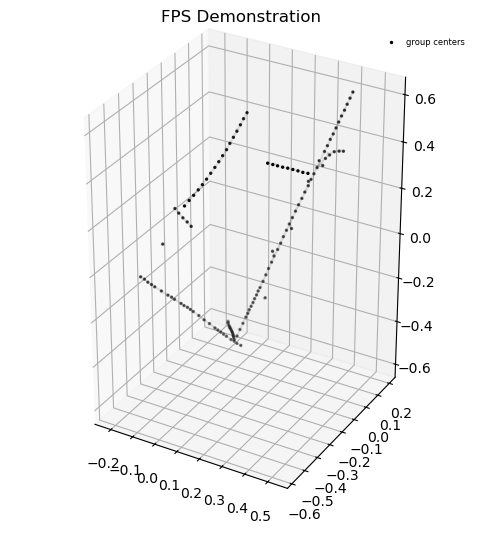

In [3]:
from point2vec.modules.grouping import sample_farthest_points

# Example showing regular FPS (not oversampled)
group_centers, idx = sample_farthest_points(
    points,
    K=128,                       # 32 centers
    lengths=lengths,            # tells the function to not consider padded points
    random_start_point=False,   # start from the first point. usually fine; if set to True incurs a decent performance hit
)

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# plot 128 group centers
event_idx = 0
ax.scatter(
    group_centers[event_idx, :, 0].cpu(),
    group_centers[event_idx, :, 1].cpu(),
    group_centers[event_idx, :, 2].cpu(),
    c='black',
    s=2,
    label='group centers'
)

# plot all points
ax.scatter(
    points[event_idx, :lengths[event_idx], 0].cpu(),
    points[event_idx, :lengths[event_idx], 1].cpu(),
    points[event_idx, :lengths[event_idx], 2].cpu(),
    c='grey',
    s=1,
    alpha=0.01,
)
plt.legend(frameon=False, fontsize=6)
plt.title('FPS Demonstration')
ax.set_aspect('equal')
plt.show()

In [4]:
from point2vec.modules.grouping import ball_query, masked_gather, fill_empty_indices

# Example showing ball query after FPS (not using NMS just yet)
group_radius = 25 / 760
_, idx, _ = ball_query(
    group_centers[:, :, :3].float(),
    points[:, :, :3].float(),
    K=512,                     # points per group
    radius=group_radius,            # 50 pixels in 760x760x760 mm^3
    lengths1=None,
    lengths2=lengths,
    return_nn=False,
)

group_lengths = (~idx.eq(-1)).sum(2)

# masked gather essentially calls torch.gather but replaces -1 indices with 0
# fill_empty_indices replaces -1 indices with the first index from its group
groups = masked_gather(points, fill_empty_indices(idx))
print('max num of points in a group:', group_lengths.max())

max num of points in a group: tensor(512, device='cuda:0')


In [5]:
# Shapes of the variables
B, N_centers, N_max, D = groups.shape
B, N_centers, D = group_centers.shape
B, N_centers = group_lengths.shape
print(f'B: {B}, N_centers: {N_centers}, N_max: {N_max}, D: {D}')

B: 24, N_centers: 128, N_max: 512, D: 4


/lscratch/youngsam/tmp/ipykernel_757620/911589754.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = center[0] + radius * np.cos(u)*np.sin(v)
/lscratch/youngsam/tmp/ipykernel_757620/911589754.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = center[1] + radius * np.sin(u)*np.sin(v)
/lscratch/youngsam/tmp/ipykernel_757620/911589754.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z = center[2] + radius * np.cos(v)


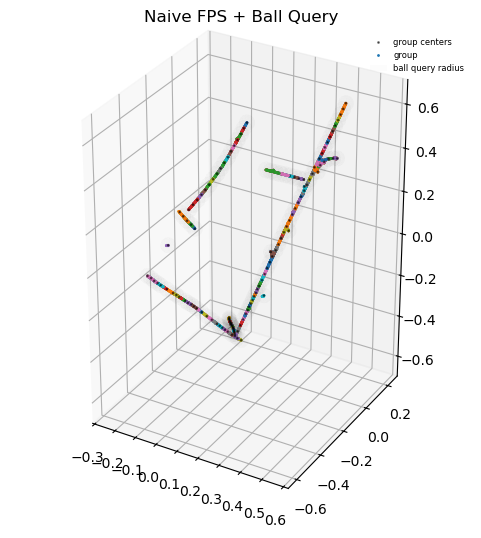

In [6]:
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# plot 32 group centers
ax.scatter(
    group_centers[event_idx, :, 0].cpu(),
    group_centers[event_idx, :, 1].cpu(),
    group_centers[event_idx, :, 2].cpu(),
    c='black',
    s=1,
    alpha=0.5,
    label='group centers'
)

# plot each group for each center
for i, length in enumerate(group_lengths[event_idx]):
    ax.scatter(
        groups[event_idx, i, :length, 0].cpu(),
        groups[event_idx, i, :length, 1].cpu(),
        groups[event_idx, i, :length, 2].cpu(),
        s=1,
        alpha=1.0,
        label='group' if i == 0 else None
    )

# plot a sphere with ball query radius
def plot_sphere(center, radius, idx=0):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = center[0] + radius * np.cos(u)*np.sin(v)
    y = center[1] + radius * np.sin(u)*np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_surface(x, y, z, color='grey', alpha=0.01, label='ball query radius' if idx == 0 else None)

for i, center in enumerate(group_centers[event_idx, :, :3].cpu()):
    plot_sphere(center, group_radius, idx=i)

plt.legend(frameon=False, fontsize=6, loc='upper right')
plt.title('Naive FPS + Ball Query')
ax.set_aspect('equal')
plt.show()

In [7]:
# Volumetric grouping

# 1. oversample group centers using FPS
group_centers, idx = sample_farthest_points(
    points,
    K=1024,                     # 1024 centers instead of 128
    lengths=lengths,            # tells the function to not consider padded points
    random_start_point=False,   # start from the first point. usually fine; if set to True incurs a decent performance hit
)

# 2. run NMS on these spheres such that no two spheres overlap greater than some ratio
from cnms import cnms
retain = cnms(group_centers, overlap_factor=2.0, radius=group_radius) # I find that 2.0 is a good overlap factor
center_lengths = retain.sum(dim=1)

# # 3. group the points into the remaining spheres using a ball query with the same radius used in step 2
_, idx, _ = ball_query(
    group_centers[:, :, :3].float(),
    points[:, :, :3].float(),
    K=2048,                     
    radius=group_radius,            
    lengths1=center_lengths,          # give only retained spheres
    lengths2=lengths,           
    return_nn=False,
)

group_point_lengths = (~idx.eq(-1)).sum(2)
groups = masked_gather(points, fill_empty_indices(idx))
print('max num of points in a group:', group_point_lengths.max().item())
print('max num of patches:', center_lengths.max().item())
print('groups shape:', groups.shape)

max num of points in a group: 978
max num of patches: 97
groups shape: torch.Size([24, 1024, 2048, 4])


As you can see, the maximum number of poinds in a group, 2048, is much larger than the actual maximum number of points in a group, 672. To fix this, we can just remove the padding of the extra points. However, this means that the number of points being embedded per group will be different for each event. This is a problem because the tokenization operation takes up a lot of memory (as it needs to lift each individual point to the embedding space). So to ensure the same number of points are embedded per group, we downsample the groups to a set maximum number of points per group, say 512. We choose which points to keep using FPS (or by taking the points with the maximum energy deposited).

In [8]:
from point2vec.modules.grouping import select_topk_by_fps, select_topk_by_energy

# Redo first oversampled ball query
_, idx, _ = ball_query(
    group_centers[:, :, :3].float(),
    points[:, :, :3].float(),
    K=2048,                     
    radius=group_radius,            
    lengths1=center_lengths,          # give only retained spheres
    lengths2=lengths,           
    return_nn=False,
)

reduction_method = 'fps'
if reduction_method == 'fps':
    idx = select_topk_by_fps(points, idx, K=512)
elif reduction_method == 'energy':
    idx = select_topk_by_energy(points, idx, K=512, energies_idx=3)

group_point_lengths = (~idx.eq(-1)).sum(2)
groups = masked_gather(points, fill_empty_indices(idx))
print('max num of points in a group:', group_point_lengths.max().item())
print('max num of patches:', center_lengths.max().item())
print('groups shape:', groups.shape)

max num of points in a group: 512
max num of patches: 97
groups shape: torch.Size([24, 1024, 512, 4])


Great! Now we have a fixed number of points per group, 512.

/lscratch/youngsam/tmp/ipykernel_757620/3725157543.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  x = center[0] + radius * np.cos(u)*np.sin(v)
/lscratch/youngsam/tmp/ipykernel_757620/3725157543.py:32: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  y = center[1] + radius * np.sin(u)*np.sin(v)
/lscratch/youngsam/tmp/ipykernel_757620/3725157543.py:33: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  z = center[2] + radius * np.cos(v)


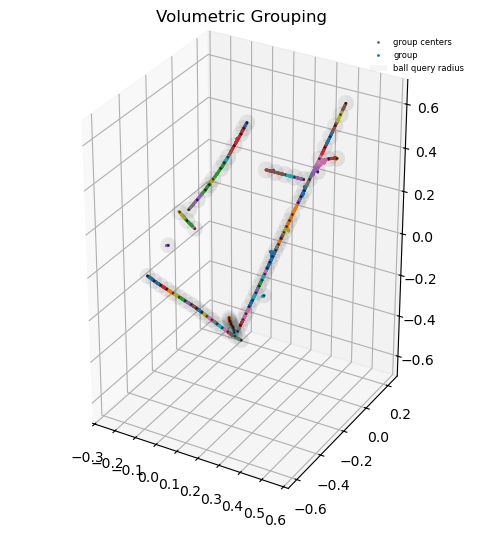

In [9]:
import numpy as np

fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')

# plot 32 group centers
ax.scatter(
    group_centers[event_idx, :center_lengths[event_idx], 0].cpu(),
    group_centers[event_idx, :center_lengths[event_idx], 1].cpu(),
    group_centers[event_idx, :center_lengths[event_idx], 2].cpu(),
    c='black',
    s=1,
    alpha=0.5,
    label='group centers'
)

# plot each group for each center
for i, length in enumerate(group_lengths[event_idx]):
    ax.scatter(
        groups[event_idx, i, :length, 0].cpu(),
        groups[event_idx, i, :length, 1].cpu(),
        groups[event_idx, i, :length, 2].cpu(),
        s=1,
        alpha=1.0,
        label='group' if i == 0 else None
    )

# plot a sphere with ball query radius
def plot_sphere(center, radius, idx=0):
    u, v = np.mgrid[0:2*np.pi:20j, 0:np.pi:10j]
    x = center[0] + radius * np.cos(u)*np.sin(v)
    y = center[1] + radius * np.sin(u)*np.sin(v)
    z = center[2] + radius * np.cos(v)
    ax.plot_surface(x, y, z, color='grey', alpha=0.05, label='ball query radius' if idx == 0 else None)

for i, center in enumerate(group_centers[event_idx, :center_lengths[event_idx], :3].cpu()):
    plot_sphere(center, group_radius, idx=i)

plt.legend(frameon=False, fontsize=6, loc='upper right')
plt.title('Volumetric Grouping')
ax.set_aspect('equal')
plt.show()

This is the general gist of the volumetric grouping method. 

Note that the new problem with this method is that now for each event we have (1) a variable number of patches and (2) a variable number of points per patch. This means that we need to pad both the number of patches and the number of points per patch and need to be very careful with the model architecture to take this into account.

You'll see this happening with many custom layers for e.g. batch and layer normalization and attention masks used in the model.

___

# 2. Moving each patch to a local coordinate system

Here we move each patch's points to a local coordinate system with the patch center as the origin to remove any global information. We also will scale the points to the unit sphere by dividing each point by the patch's radius. (This is not strictly necessary but I found it helps with the model's performance.)

It is these patches after this transformation that are fed into the tokenizer, and will eventually be used as ground truth for the model when predicting the masked patches.

In [10]:
# note we only subtract of the group center for the x,y,z coordinates, and not energy. 
# this is because we want to keep the energy information in the relative coordinates.
# I experimented with also subtracting the energy, but found that it was not helpful.

groups[:, :, :, :3] = groups[:, :, :, :3] - group_centers[:, :, None, :3]
groups[:, :, :, :3] = groups[:, :, :, :3] / group_radius

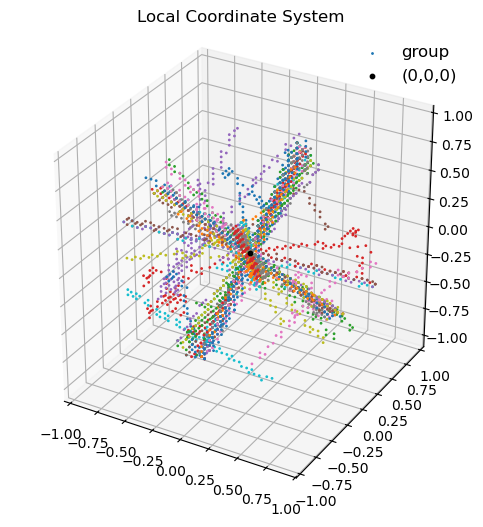

In [11]:
fig = plt.figure(figsize=(6, 6))
ax = fig.add_subplot(111, projection='3d')
# plot each group for each center
for i, length in enumerate(group_point_lengths[event_idx].cpu()):
    ax.scatter(
        groups[event_idx, i, :length, 0].cpu(),
        groups[event_idx, i, :length, 1].cpu(),
        groups[event_idx, i, :length, 2].cpu(),
        s=1,
        alpha=1,
        label='group' if i == 0 else None
    )
ax.scatter(0,0,0, c='black', s=10, label='(0,0,0)')
plt.legend(frameon=False, fontsize=12)
plt.title('Local Coordinate System')
ax.set_aspect('equal')
plt.show()

___

# 3. Embedding each patch into a single high dimension latent vector using mini PointNet

We use a mini PointNet to embed each patch into a single high dimension latent vector. This is done by first passing the points through a series of convolutional layers to extract features, and then taking the maximum value across the points in each dimension, in each patch.

I.e., $$ f(\{x_1, x_2, ..., x_n\}) \approx g(h(x_1), h(x_2), ..., h(x_n)) $$

where $f$ is the function we want to approximate, $g$ is the max pooling operation, and $h$ is MLP. See PointNet paper for more details.

In [12]:
from point2vec.modules.masking import MaskedBatchNorm1d
import torch.nn as nn

class MaskedMiniPointNet(nn.Module):
    def __init__(self, channels: int, feature_dim: int):
        super().__init__()
        self.first_conv = nn.Sequential(
            nn.Conv1d(channels, 128, 1, bias=False),
            MaskedBatchNorm1d(128),
            nn.ReLU(inplace=True),
            nn.Conv1d(128, 256, 1),
        )

        self.second_conv = nn.Sequential(
            nn.Conv1d(512, 512, 1, bias=False),
            MaskedBatchNorm1d(512),
            nn.ReLU(inplace=True),
            nn.Conv1d(512, feature_dim, 1),
        )

    def forward(self, points, mask) -> torch.Tensor:
        # points: (B, N, C)
        # mask: (B, 1, N)

        feature = points.transpose(2, 1)  # (B, C, N)
        for layer in self.first_conv:
            if isinstance(layer, MaskedBatchNorm1d):
                feature = layer(feature, mask)
            else:
                feature = layer(feature)

        # (B, feature_dim, N) --> (B, feature_dim, 1)
        feature_global = torch.max(feature, dim=2, keepdim=True).values  # (B, feature_dim, 1)
        # concating global features to each point features
        feature = torch.cat(
            [feature_global.expand(-1, -1, feature.shape[2]), feature], dim=1
        )  # (B, feature_dim * 2, N)

        for layer in self.second_conv:
            if isinstance(layer, MaskedBatchNorm1d):
                feature = layer(feature, mask)
            else:
                feature = layer(feature)

        # (B, feature_dim, N) --> (B, feature_dim)
        feature_global = torch.max(feature, dim=2).values  # (B, feature_dim)
        return feature_global

In [13]:
# Removing all but first `context_length` groups as the rest were removed with NMS
context_length = 128
groups = groups[:, :context_length]
group_point_lengths = group_point_lengths[:, :context_length]
group_centers = group_centers[:, :context_length]

Here we have a set context length, 128, for the tokenizer. This could be set dynamically (i.e. the max number of groups to keep after NMS), but this means that the per-batch load would not be the same. To ensure that we don't get a random out of memory error for an unusually large event, we set a maximum context length, just as we did with the maximum group size.

Note that now we must ensure that our context length and group size are good enough to be large enough that we don't lose any information, but small enough so that we don't run out of memory. This is empirically found by trial and error.

In [14]:
mini_pointnet = MaskedMiniPointNet(channels=4, feature_dim=384).cuda()

# To perform batch normalization, we need a mask that tells us which points are valid to normalize. Otherwise
# we will be computing batch statistics on padded points, which is not what we want.
B, G, K, C = groups.shape
point_mask = torch.arange(K, device=idx.device).expand(groups.size(0), context_length, -1) < group_point_lengths.unsqueeze(-1)
B, G, K = point_mask.shape

# perform mini PointNet on each group individually
embeddings = mini_pointnet(groups.reshape(B * G, K, C), point_mask.reshape(B * G, 1, K)).reshape(B, G, -1)

In [49]:
embeddings.shape

torch.Size([24, 128, 384])

Great! Now we've successfully embedded each group into a single, high dimension, localized latent vector. After adding back the context of the group center via a learned positional embedding, these will be fed into the transformer.

___

# Actual usage

We use `PoincloudTokenizer` in `point2vec.modules.pointnet` to do this grouping, transformation, and embedding at once.

In [16]:
from point2vec.modules.pointnet import PointcloudTokenizer

tokenizer = PointcloudTokenizer(
    num_init_groups=1024,            # oversample group centers using FPS
    group_size=512,                  # final group size for ball query
    group_radius=25 / 760,           # ball query radius
    context_length=128,             # number of groups to keep after NMS
    upscale_group_size=2048,         # upscale group size for ball query
    overlap_factor=2.0,              # overlap factor for NMS
    token_dim=384,                   # embedding dimension
    num_channels=4,                  # number of channels in the input points
    embedding_type='masked_mini',    # embedding type -- always use masked mini PointNet
    reduction_method='fps',           # reduction method for group centers
).cuda()

In [19]:
(
    embeddings,
    group_center,
    embedding_mask,
    semantic_id_groups,
    endpoints_groups,
) = tokenizer(
    points,
    lengths,
    semantic_id=None,
    endpoints=None,
)

# or if you want the grouped points as well

(
embeddings,
group_center,
embedding_mask,
semantic_id_groups,
endpoints_groups,
group,
point_mask,
) = tokenizer(
    points,
    lengths,
    semantic_id=None,
    endpoints=None,
    return_point_info=True,
)

embeddings.shape

torch.Size([24, 128, 384])